In [ ]:
# JUST FOR TESTING PURPOSES, DATASET CREATION IN run_gnn_model

In [1]:
import sys
#print(sys.path)
# sys.path.insert(0, '/eos/user/c/czeh/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

input_folder = "/eos/user/c/czeh/histo/"
output_folder = "/eos/user/c/czeh/graph_data"

The scikit-learn version is 1.5.1.
Python version
3.11.9 (main, Jun 24 2024, 14:32:54) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


In [25]:
import os
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import Data

import awkward as ak
import numpy as np
import uproot as uproot
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# use this to load the tree if some of file.keys() are duplicates ending with different numbers
def load_branch_with_highest_cycle(file, branch_name):

    # Get all keys in the file
    all_keys = file.keys()

    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]

    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")

    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))

    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]

    return branch

In [34]:
# input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv5Performance/CloseByPionPU/histo/"
files = glob(f"{input_folder}/*.root")
print(range(len(files)))
file = uproot.open(files[0])

alltracksters = load_branch_with_highest_cycle(file,'ticlDumper/trackstersCLUE3DHigh')
allclusters = load_branch_with_highest_cycle(file,'ticlDumper/clusters')
allsimtrackstersCP = load_branch_with_highest_cycle(file, 'ticlDumper/simtrackstersCP')
allassociations = load_branch_with_highest_cycle(file, 'ticlDumper/associations')
alltracks = load_branch_with_highest_cycle(file, 'ticlDumper/tracks')
allsuperclustering = load_branch_with_highest_cycle(file, 'ticlDumper/superclustering')
print(alltracksters.show())
print(allclusters.show())

range(0, 5)
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | edm::EventID             | AsGroup(<TBranchElement 'ev...
event/run_           | uint32_t                 | AsDtype('>u4')
event/luminosityB... | uint32_t                 | AsDtype('>u4')
event/event_         | uint64_t                 | AsDtype('>u8')
NTracksters          | uint32_t                 | AsDtype('>u4')
NClusters            | uint32_t                 | AsDtype('>u4')
time                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
timeError            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
regressed_energy     | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_energy           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_em_energy        | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_pt         

In [5]:
node_feature_keys_before = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "raw_energy", "raw_em_energy", "time"]
data = alltracksters.arrays(node_feature_keys_before)
data

<Array [{barycenter_x: [...], ...}, ..., {...}] type='10 * {barycenter_x: v...'>

In [6]:
num_LCs = ak.count(alltracksters.arrays().vertices_indexes, axis=2)
data["num_LCs"] = num_LCs

In [7]:
data["z_min"] = ak.min(alltracksters.arrays().vertices_z, axis=2)
data["z_max"] = ak.max(alltracksters.arrays().vertices_z, axis=2)

In [87]:
hits = ak.to_list(np.zeros_like(data.num_LCs))
length = ak.to_list(np.zeros_like(data.num_LCs))
density = ak.to_list(np.zeros_like(data.num_LCs))

volume = 2*(3 - 1.5) * (2 * 47)
data["LC_density"] = data.num_LCs / volume

cluster_number_of_hits = allclusters.arrays().cluster_number_of_hits
cluster_layer_id = allclusters.arrays().cluster_layer_id
vertices_indexes = alltracksters.arrays().vertices_indexes
NTracksters = alltracksters.arrays().NTracksters

for i in tqdm(range(len(alltracksters.arrays()))):
    for j in range(alltracksters.arrays().NTracksters[i]):
        hits[i][j] = ak.sum(cluster_number_of_hits[i][vertices_indexes[i][j]])
        length[i][j] = (ak.max(cluster_layer_id[i][vertices_indexes[i][j]]) - ak.min(cluster_layer_id[i][vertices_indexes[i][j]])) / 47
        density[i][j] = NTracksters[i] / volume
        
data["num_hits"] = hits
data["length"] = length
data["trackster_density"] = density

100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


In [90]:
data["photon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 0]
data["electron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 1]
data["muon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 2]
data["neutral_pion_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 3]
data["charged_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 4]
data["neutral_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 5]

In [91]:
edges = allsuperclustering.arrays().linkedResultTracksters
data["y"] = [edges[ak.num(edges) > 1]

In [93]:
data[0]["y"]

<Array [[2985, 2568], [913, 1518], ..., [2504]] type='46 * var * uint32'>

In [11]:
node_feature_keys = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "LC_density", "trackster_density", "time"]
thesis_feature_names = ["x", "y", "z", "eta", "phi", "eig_x", "eig_y", "eig_z",  "EV1", "EV2", "EV3", "sigmaPCA_x", "sigmaPCA_y", "sigmaPCA_z", "num_LC", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "LC_density", "trackster_density", "time"]

100%|██████████| 29/29 [00:13<00:00,  2.23it/s]
/tmp/ipykernel_413/3466913950.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


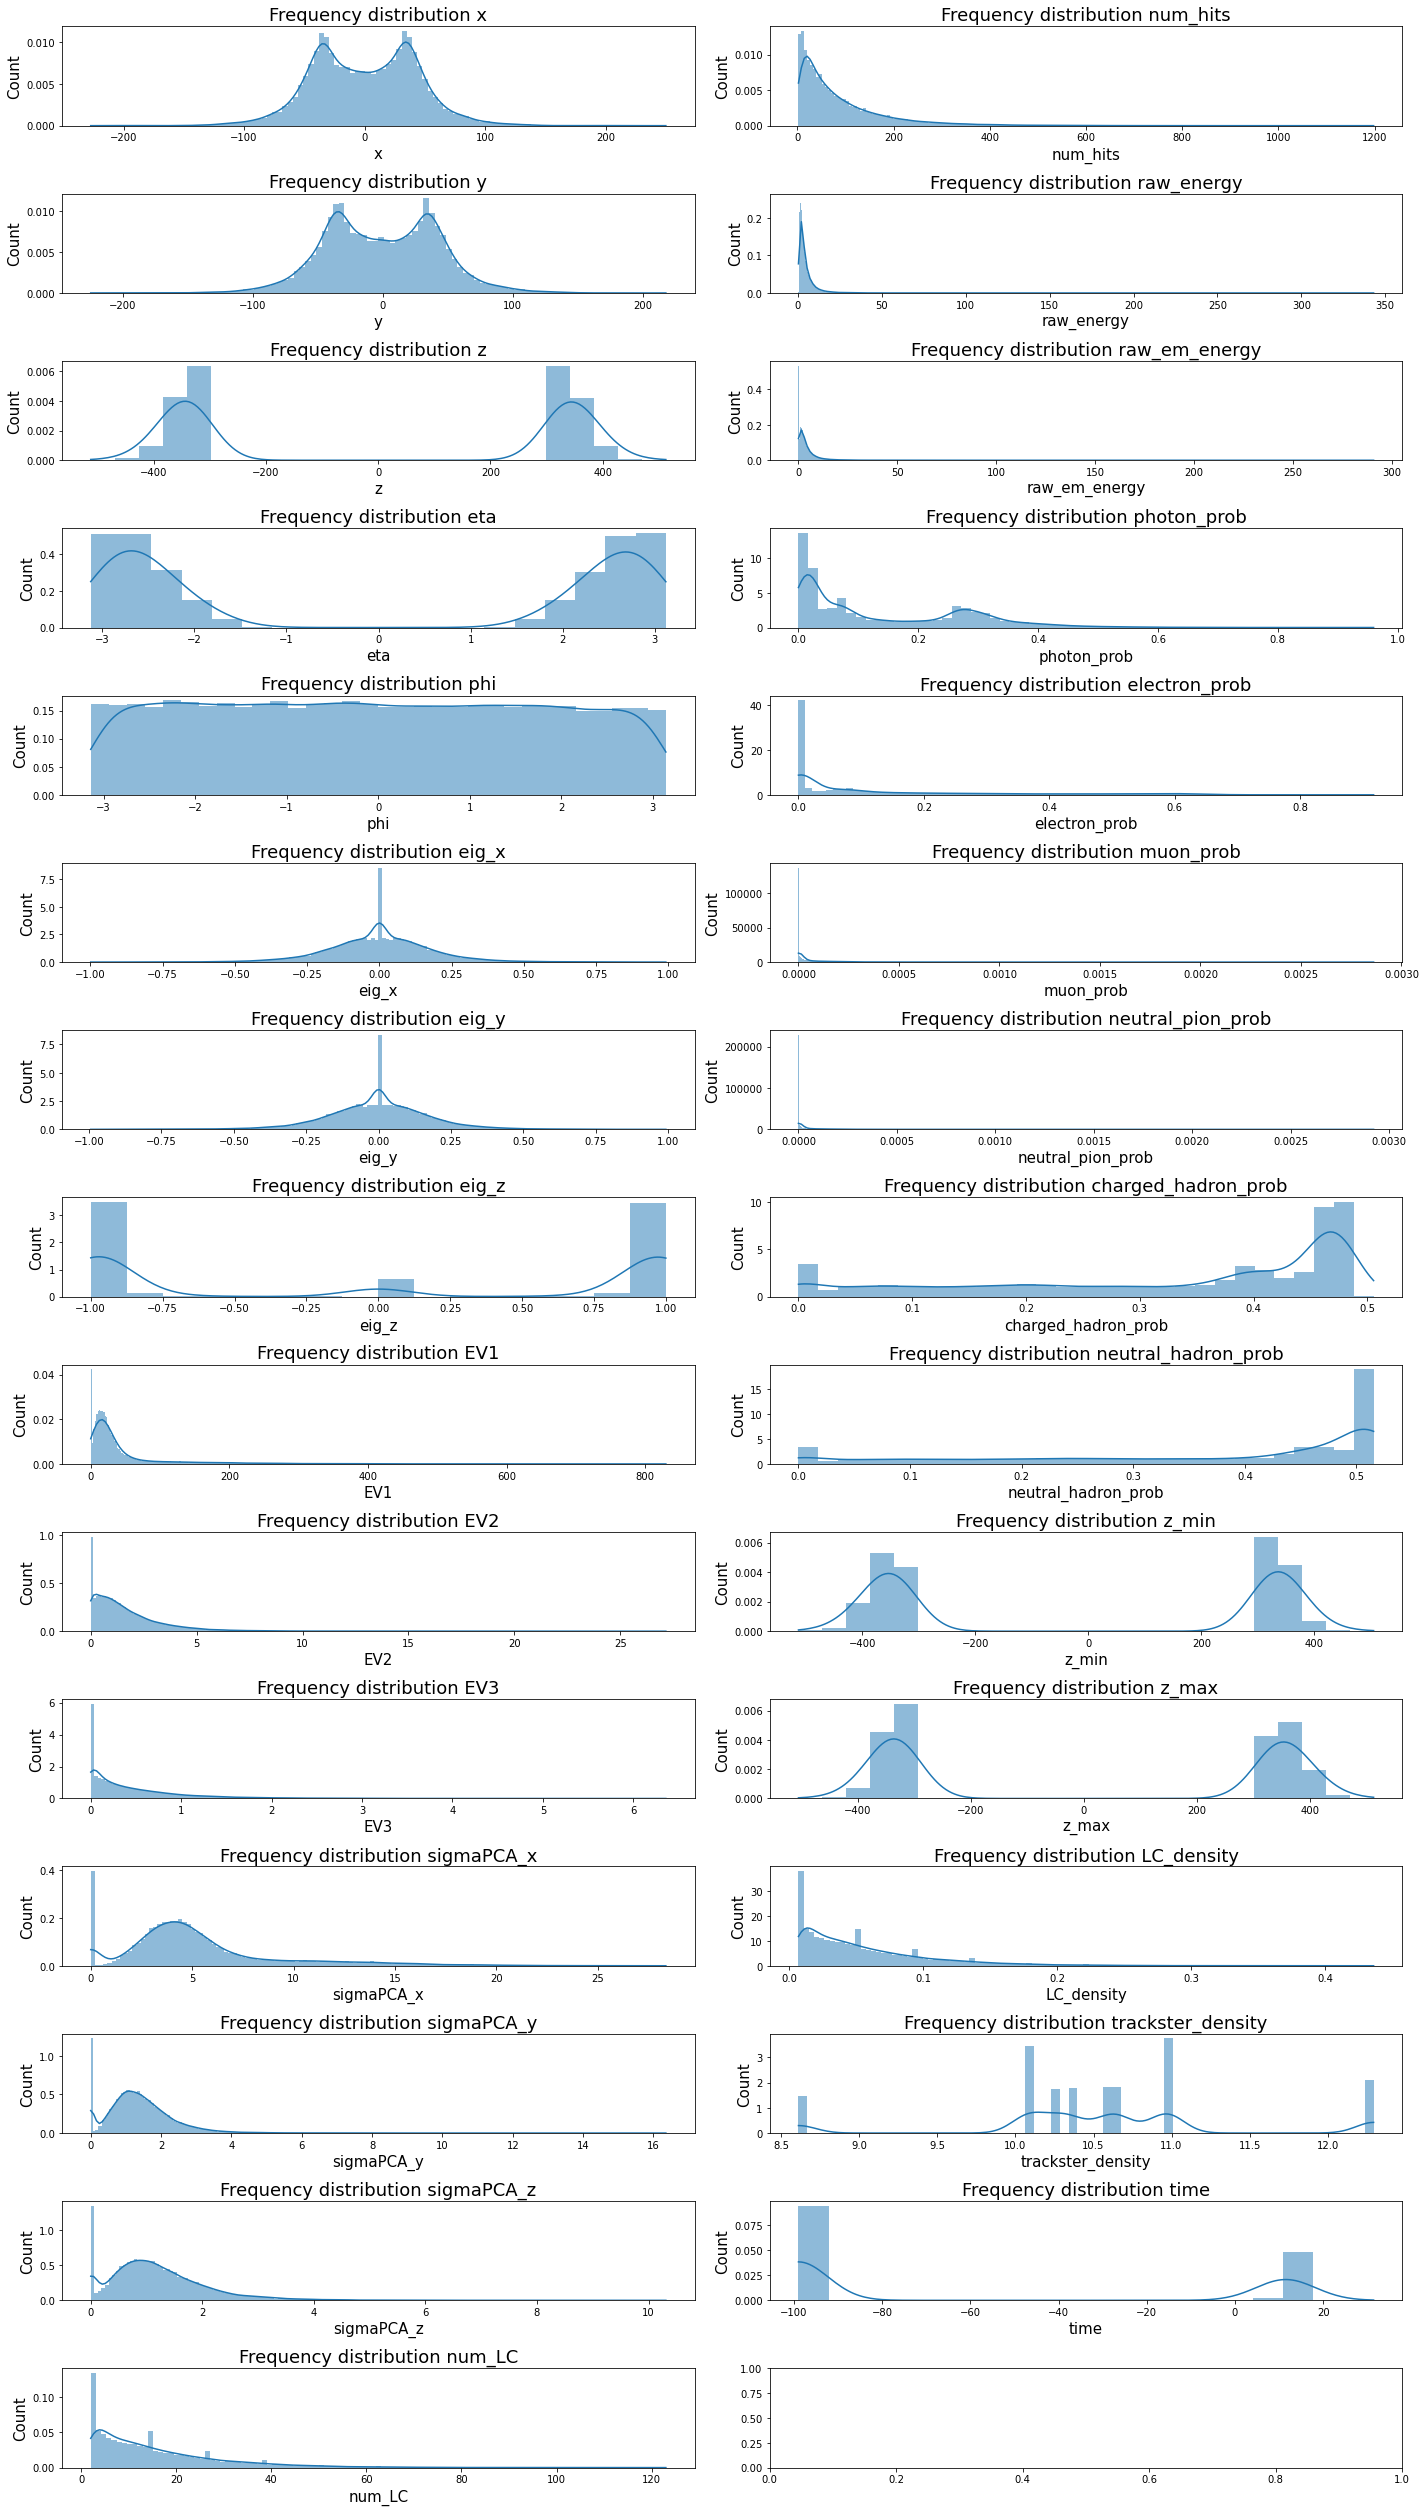

In [12]:
track_vals = []

scols = int(np.ceil(len(node_feature_keys)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_keys))):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    values = ak.flatten(data[node_feature_keys[i]])
    track_vals.append(values)
    sns.histplot(values, ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ thesis_feature_names[i], fontsize=18)
    axes[ax_col, ax_row].set_xlabel(thesis_feature_names[i], fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [13]:
track_vals = np.array(track_vals)

In [14]:
corr_matrix = np.corrcoef(track_vals)
print(corr_matrix.shape)

(29, 29)


Text(0.5, 1.0, 'Correlation Matrix of the Trackster Features')

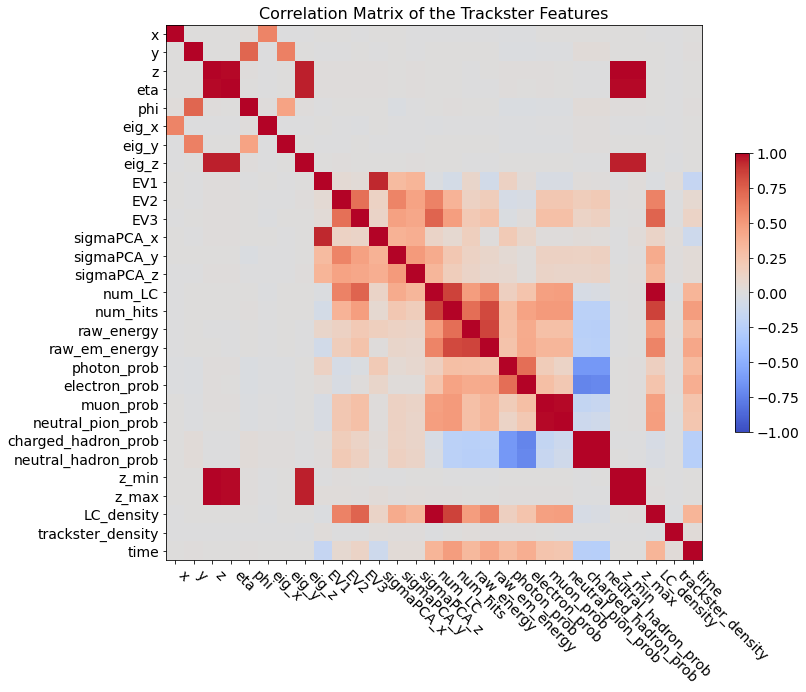

In [15]:
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(range(len(thesis_feature_names)), thesis_feature_names, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(thesis_feature_names)), thesis_feature_names, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)

In [76]:
graph_list = []
for event in range(len(NTracksters)):    
    nodes = np.zeros((NTracksters[event], len(node_feature_keys)))
    for i, key in enumerate(node_feature_keys):
        nodes[:, i] = ak.to_numpy(data[event][key])

    edges = [[], []]
    for i in range(NTracksters[event]):
        edges[0].extend([i] * (NTracksters[event]))
        edges[1].extend(list(range(NTracksters[event])))
    edges = np.array(edges)
    
    y = allsuperclustering.arrays()[event].linkedResultTracksters
    y = ak.to_numpy(y[ak.num(y) > 1])
    
    nodes = torch.from_numpy(nodes)
    edge_index = torch.from_numpy(edges)
    y = torch.from_numpy(y)

    graph_list.append(Data(x=nodes, num_nodes=NTracksters[event],
                        edge_index=edge_index, y=y))

In [78]:
graph_list

[Data(x=[3090, 29], edge_index=[2, 9548100], y=[13, 2], num_nodes=3090),
 Data(x=[2994, 29], edge_index=[2, 8964036], y=[13, 2], num_nodes=2994),
 Data(x=[3096, 29], edge_index=[2, 9585216], y=[13, 2], num_nodes=3096),
 Data(x=[3002, 29], edge_index=[2, 9012004], y=[13, 2], num_nodes=3002),
 Data(x=[2428, 29], edge_index=[2, 5895184], y=[13, 2], num_nodes=2428),
 Data(x=[2921, 29], edge_index=[2, 8532241], y=[13, 2], num_nodes=2921),
 Data(x=[2846, 29], edge_index=[2, 8099716], y=[13, 2], num_nodes=2846),
 Data(x=[3467, 29], edge_index=[2, 12020089], y=[13, 2], num_nodes=3467),
 Data(x=[2844, 29], edge_index=[2, 8088336], y=[13, 2], num_nodes=2844),
 Data(x=[2900, 29], edge_index=[2, 8410000], y=[13, 2], num_nodes=2900)]

[28, 28, 28, 28, 28, 28, 28, 28, 28, 28]

In [75]:
# y
y = allsuperclustering.arrays()[0].linkedResultTracksters
ak.to_numpy(y[ak.num(y) > 1])

array([[2985, 2568],
       [ 913, 1518],
       [1762, 1638],
       [2315, 1793],
       [ 569,  575],
       [2150, 2714],
       [1663, 1861],
       [2025, 2101],
       [ 571,  370],
       [ 620,  277],
       [ 524,   89],
       [2050, 1675],
       [ 528,  186]], dtype=uint32)